In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# Our Model

[52 56 49 35  7  1]
2/3 of Average Choice: 23.26


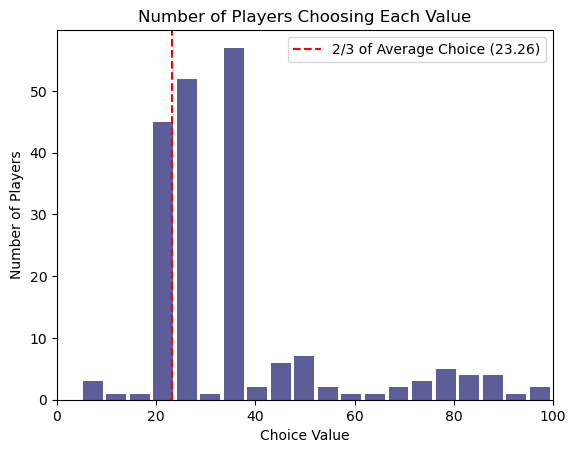

Maximum level of reasoning:  5
Average degree of the network:  38.16
Number of nodes in the network:  200


In [86]:
def belief_function(G, node):
    # Getting the outgoing neighbors (for directed graph)
    neighbors = list(G.successors(node))
    if not neighbors:
        # If no outgoing links, belief is a random number between 0 and node's level - 1
        return random.uniform(0, G.nodes[node]['level'] - 1)
    else:
        # The belief is the average level of the outgoing links
        return np.mean([G.nodes[neighbor]['level'] for neighbor in neighbors])


def choice_function(G, node):
    level = G.nodes[node]['level']
    # Randomly choose between a strategic choice and a completely random choice
    avg_belief = belief_function(G, node)
    # Strategic choice based on the average belief
    if level == 0:
        return random.uniform(0, 100)
    else:
        return ((2/3)**(avg_belief + 1)) * 50

# def generate_directed_network(level_counts, p):
#     G = nx.DiGraph()
#     node_count = 0

#     # Add nodes with their levels
#     for level, count in enumerate(level_counts):
#         for _ in range(count):
#             G.add_node(node_count, level=level)
#             node_count += 1

#     # Connect nodes
#     if p == 1:
#         # In the case of p=1, connect each node in level k to all nodes in levels 0 to k-1
#         for node in G.nodes:
#             node_level = G.nodes[node]['level']
#             for lower_level_node in G.nodes:
#                 if G.nodes[lower_level_node]['level'] < node_level:
#                     G.add_edge(node, lower_level_node)
#     elif p == 0:
#         # In the case of p=0, return the graph with no edges
#         pass
#     else:
#         # Calculate modified probability for other cases
#         kappa = len(level_counts)
#         p_hat = (p * (1 - p)) / (1 - p ** (kappa - 1))

#         # Connect nodes based on calculated probabilities
#         for node in G.nodes:
#             node_level = G.nodes[node]['level']
#             for target_level in range(kappa):
#                 if node_level > target_level:
#                     prob = (p_hat**(node_level - target_level)) * level_counts[target_level]
#                     prob /= sum((p_hat**(node_level - k)) * level_counts[k] for k in range(node_level))
#                     for target_node in G.nodes:
#                         if G.nodes[target_node]['level'] == target_level and random.random() < prob:
#                             G.add_edge(node, target_node)

#     return G
    

def generate_directed_network(level_counts, p):
    G = nx.DiGraph()
    level_nodes = {}  # Store nodes of each level

    # Create nodes and assign levels
    node_counter = 0
    for level, count in enumerate(level_counts):
        nodes = list(range(node_counter, node_counter + count))
        # Assign level as node attribute
        for node in nodes:
            G.add_node(node, level=level)
        level_nodes[level] = nodes
        node_counter += count

    # Connect nodes with corrected probability calculations
    for k in range(1, len(level_counts)):  # For each level k (except level 0)
        # p_hat = (p * (1 - p)) / (1 - p ** (k - 1)) if k > 1 else p  # Normalize p_hat for each k
        p_hat = p

        # Calculate denominator for the connection probability
        denominator = sum(p_hat ** (k - kappa) * len(level_nodes[kappa]) for kappa in range(k))

        for node in level_nodes[k]:
            for kappa in range(k):  # Connect to levels below k
                numerator = p_hat ** (k - kappa) * len(level_nodes[kappa])
                probability = numerator / denominator
                
                # Determine number of connections based on calculated probability
                connections = int(probability * len(level_nodes[kappa]))
                
                if connections > 0:
                    target_nodes = np.random.choice(level_nodes[kappa], connections, replace=False)
                    for target in target_nodes:
                        G.add_edge(node, target)

    return G


def plot_choice_frequency(G):
    # Calculate choices for all nodes
    choices = [choice_function(G, node) for node in G.nodes]

    # Plotting the actual number of players choosing each value
    plt.hist(choices, bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Choice Value')
    plt.ylabel('Number of Players')
    plt.title('Number of Players Choosing Each Value')
    plt.xlim(0, 100)

    # Marking the 2/3 of the average of all choices with a dashed line
    avg_choice = np.mean(choices)
    plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
    print(f'2/3 of Average Choice: {(2/3) * avg_choice:.2f}')
    plt.legend()

    # plt.savefig('k-level synthetic experiments-Game choices.png', dpi=60)
    plt.show()


# Parameters
# Define the mean (λ) of the Poisson distribution
lambda_ = 1.5
# Define the number of levels
num_players = 200

# Generate the level counts using the Poisson distribution
player_levels = np.random.poisson(lambda_, num_players)
level_counts = np.bincount(player_levels)
print(level_counts)


p = 0.9
network = generate_directed_network(level_counts, p)

# Plot the choice frequency for the generated network
plot_choice_frequency(network)
print("Maximum level of reasoning: ", len(level_counts)-1)
print("Average degree of the network: ", network.number_of_edges()/network.number_of_nodes())
print("Number of nodes in the network: ", network.number_of_nodes())

Average degree of the network:  1.6363636363636365


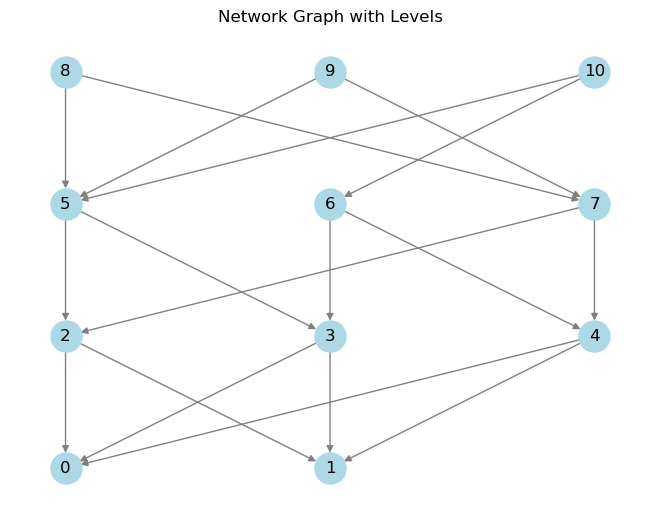

In [88]:
def plot_graph_with_levels(G):
    # Determine the number of levels
    levels = set(nx.get_node_attributes(G, 'level').values())
    max_level = max(levels) + 1

    # Create a position dictionary for each node
    pos = {}
    for level in range(max_level):
        nodes_at_level = [node for node, attr in G.nodes(data=True) if attr['level'] == level]
        level_pos = {node: (i, -level) for i, node in enumerate(nodes_at_level)}
        pos.update(level_pos)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title('Network Graph with Levels')
    plt.gca().invert_yaxis()  # Invert y-axis to have lower levels at the bottom
    plt.savefig('k-level synthetic experiments-Example Network.png', dpi=600)
    plt.show()

level_counts_plot = [2, 3, 3, 3]  # Number of players in each level
p_plot = 0.1
network_plot = generate_directed_network(level_counts_plot, p_plot)
# average degree of the network
print("Average degree of the network: ", network_plot.number_of_edges()/network_plot.number_of_nodes())

# Plotting the graph
plot_graph_with_levels(network_plot)


[44 66 50 26  7  4  3]
Average degree for p=0.1: 39.62
Average degree for p=0.3: 39.87
Average degree for p=0.7: 39.68
Average degree for p=1: 76.15


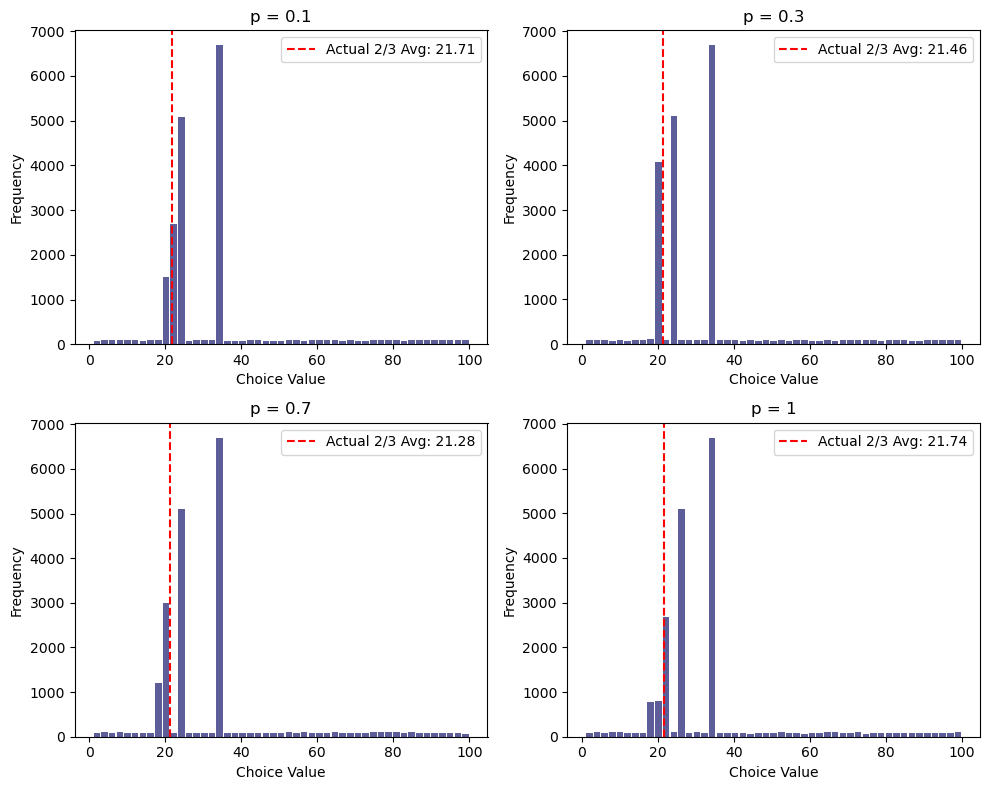

In [54]:
def average_choice_frequency_over_instances(level_counts, p, num_instances):
    all_choices = []
    average_degree = 0

    for _ in range(num_instances):
        # Generate the network for each instance
        network = generate_directed_network(level_counts, p)

        # Calculate choices for all nodes in this instance
        choices = [choice_function(network, node) for node in network.nodes]
        all_choices.extend(choices)

        average_degree += network.number_of_edges()/network.number_of_nodes()
    
    average_degree /= num_instances

    return all_choices, average_degree

# Parameters
# Define the mean (λ) of the Poisson distribution
lambda_ = 1.5
# Define the number of levels
num_players = 200

# Generate the level counts using the Poisson distribution
player_levels = np.random.poisson(lambda_, num_players)
level_counts = np.bincount(player_levels)
print(level_counts)


p_values = [0.1, 0.3, 0.7, 1]  # Different probabilities to be tested
num_instances = 100  # Number of instances to average over

fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 subplot grid
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for i, p in enumerate(p_values):
    # Calculate the average choice frequency over multiple instances
    average_choices, average_degree = average_choice_frequency_over_instances(level_counts, p, num_instances)
    print(f"Average degree for p={p}: {average_degree:.2f}")

    # Calculate the actual average of all choices
    actual_avg_choice = np.mean(average_choices)

    # Plot the average choice frequency on the ith subplot
    axs[i].hist(average_choices, bins=np.linspace(1, 100, 50), color='midnightblue', alpha=0.7, rwidth=0.85)
    axs[i].axvline(2*actual_avg_choice/3, color='red', linestyle='--', label=f'Actual 2/3 Avg: {2*actual_avg_choice/3:.2f}')
    axs[i].set_xlabel('Choice Value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'p = {p}')
    axs[i].legend()

plt.tight_layout()
# plt.savefig('k-level synthetic experiments-Average choice frequency.png', dpi=600)
plt.show()

# Distance

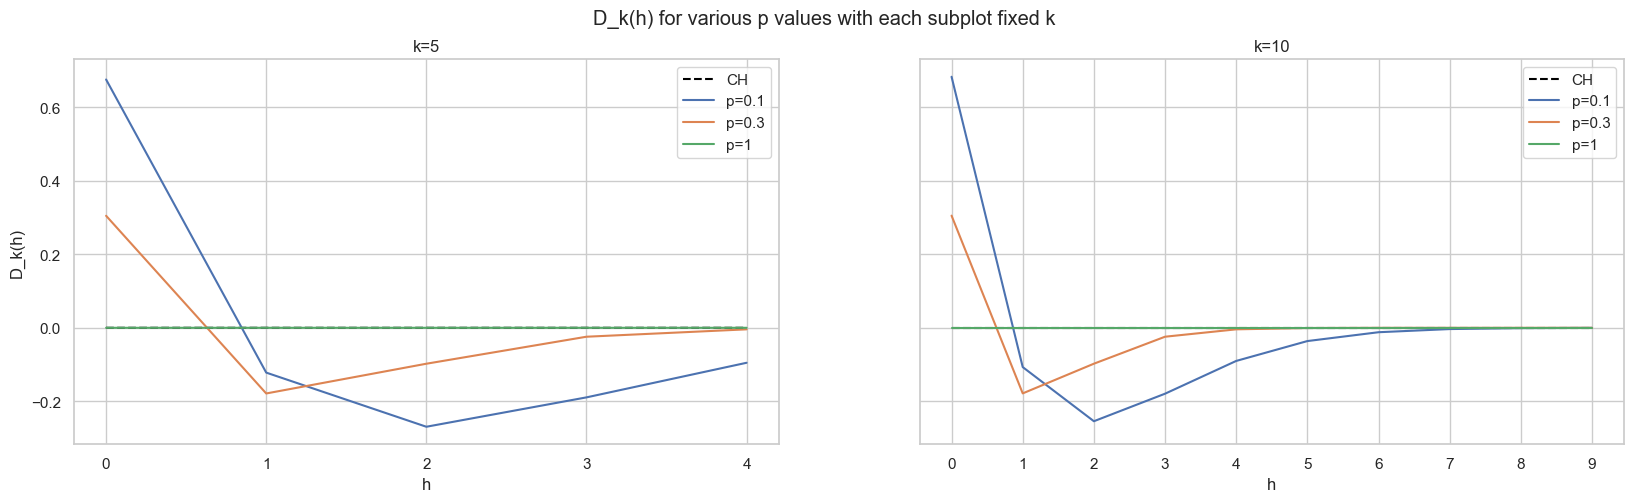

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import poisson, binom, geom, nbinom, hypergeom, randint

# Define parameters
lambda_poisson = 0.2  # Mean rate of the Poisson distribution
max_h = 20  # Define the maximum h value we will calculate
f_values = poisson.pmf(np.arange(max_h), lambda_poisson)  # Pre-compute f(h) values

# print(sum(f_values))  # Check if the sum of f(h) values is 1

# Function to get f(h) from pre-computed values
def f(h):
    if h < len(f_values):
        return f_values[h]
    return 0  # Return 0 if h is out of the pre-computed range

def D_CH_model(h, k):
    numerator = f(h)
    # Ensure that the range of j is from 0 to k-1
    denominator = sum(f(j) for j in range(k))
    return f(h) - (numerator / denominator) if denominator != 0 else 0

# Function to calculate g_k(h) given PMF f
def g_k(h, k, p):
    numerator = p**(k-h) * f(h)
    denominator = sum(p**(k-j) * f(j) for j in range(k))
    return numerator / denominator if denominator != 0 else 0

# Compute D_k(h)
def D_k(h, k, p):
    return f(h) - g_k(h, k, p)

def g_2_k(alpha, h, k):
    numerator = f(h)**alpha
    denominator = sum(f(j)**alpha for j in range(k))
    return numerator / denominator if denominator != 0 else 0


# Parameters
p_values = [0.1, 0.3, 1]  # Different values for p
k_values = [5, 10]  # k values, starting from 1 to avoid empty ranges


# Plotting using Seaborn for each k
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 5), sharey=True)
fig.suptitle('D_k(h) for various p values with each subplot fixed k')

# Plotting loop
for idx, k in enumerate(k_values):
    h_values = list(range(k))

    CH = [D_CH_model(h, k) for h in h_values]
    sns.lineplot(ax=axes[idx], x=h_values, y=CH, label=f'CH', color='black', linestyle='--')
    
    for p in p_values:
        D_values = [D_k(h, k, p) for h in h_values]
        sns.lineplot(ax=axes[idx], x=h_values, y=D_values, label=f'p={p}')
    axes[idx].set_title(f'k={k}')
    axes[idx].set_xlabel('h')
    axes[idx].set_xticks(h_values)
    axes[idx].set_ylabel('D_k(h)' if idx == 0 else '')
    axes[idx].legend()

plt.show()

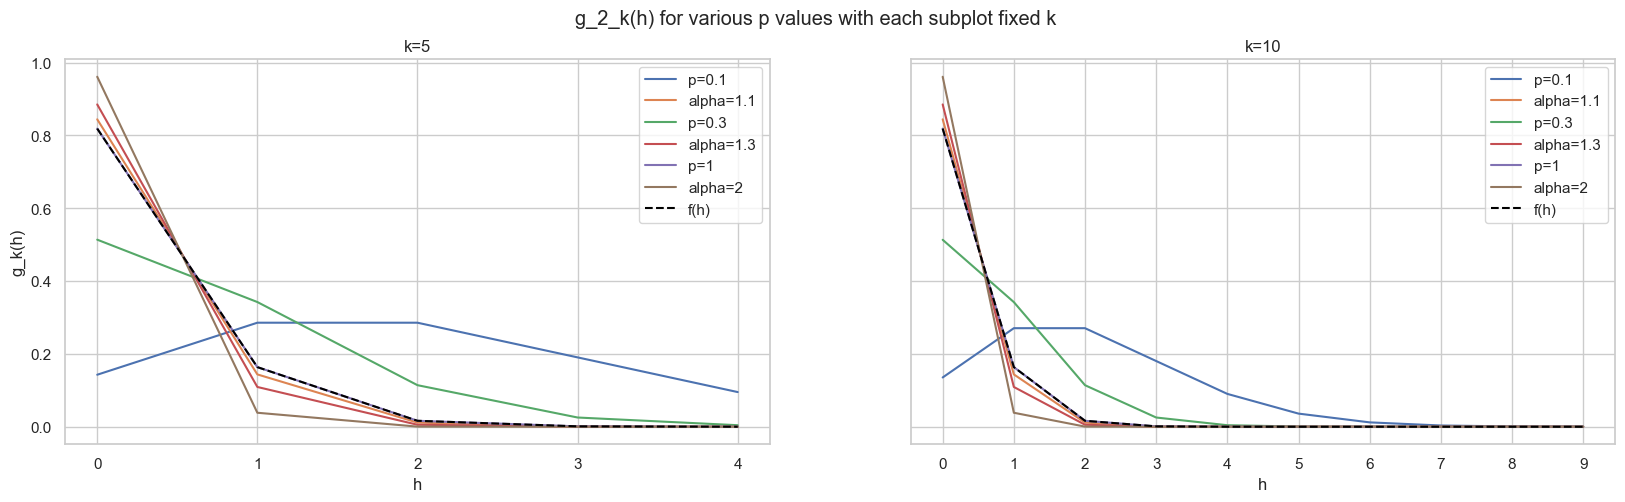

In [16]:
# plot g_k(h) for k values
# sns.set(style="whitegrid")
# fig, axes = plt.subplots(1, len(k_values), figsize=(20, 5), sharey=True)
# fig.suptitle('g_k(h) for various p values with each subplot fixed k')

# plot g_2_k(h) for k values
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(k_values), figsize=(20, 5), sharey=True)
fig.suptitle('g_2_k(h) for various p values with each subplot fixed k')

# Plotting loop
for idx, k in enumerate(k_values):
    h_values = list(range(k))
    for p in p_values:
        alpha = p+1
        g_values = [g_k(h, k, p) for h in h_values]
        sns.lineplot(ax=axes[idx], x=h_values, y=g_values, label=f'p={p}')

        g_values = [g_2_k(alpha, h, k) for h in h_values]
        sns.lineplot(ax=axes[idx], x=h_values, y=g_values, label=f'alpha={alpha}')

    sns.lineplot(ax=axes[idx], x=h_values, y=[f(h) for h in h_values], label=f'f(h)', color='black', linestyle='--')
    axes[idx].set_title(f'k={k}')
    axes[idx].set_xlabel('h')
    axes[idx].set_xticks(h_values)
    axes[idx].set_ylabel('g_k(h)' if idx == 0 else '')
    axes[idx].legend()